# Low Rank Matrix Completion

In [1]:
import os
import torch
import pandas as pd
import numpy as np
from PIL import Image
import clip
from sklearn.preprocessing import StandardScaler
import hdbscan
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from IPython.display import display, HTML 

In [2]:
# load data
excel_path = "/Users/laurali/Desktop/Spring 25/STAT 4830/STAT-4830-vllm-project/dataset.xlsx"
df = pd.read_excel(excel_path, sheet_name='Sheet1')

# If the first column is useless, drop it
df.drop(df.columns[0], axis=1, inplace=True)

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   brand        73 non-null     object 
 1   name         73 non-null     object 
 2   description  73 non-null     object 
 3   price        73 non-null     float64
 4   user         73 non-null     object 
dtypes: float64(1), object(4)
memory usage: 3.0+ KB


In [3]:
#load clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [4]:
image_folder = "/Users/laurali/Desktop/Spring 25/STAT 4830/STAT-4830-vllm-project/dataset"
df["text_embedding"] = None
df["image_embedding"] = None

In [5]:
for idx, row in df.iterrows():
    # ----------------------------------
    # a) Find the corresponding image file
    # ----------------------------------
    # As per your description, for row i in df, 
    # the image file is named (i+2).jpg or (i+2).png
    image_number = idx + 2
    jpg_path = os.path.join(image_folder, f"{image_number}.jpg")
    png_path = os.path.join(image_folder, f"{image_number}.png")

    # Convert .jpg to .png if needed
    if os.path.isfile(jpg_path) and not os.path.isfile(png_path):
        try:
            img = Image.open(jpg_path).convert("RGB")
            img.save(png_path, "PNG")  # Save as PNG
            os.remove(jpg_path)  # Delete original JPG
            print(f"Converted {jpg_path} → {png_path}")
        except Exception as e:
            print(f"Error converting {jpg_path}: {e}")

    image_path = png_path if os.path.isfile(png_path) else None

    if not image_path:
        print(f"Warning: No image found for row {idx}, expected {image_number}.png")
        continue

    # ----------------------------------
    # b) Load text and image
    # ----------------------------------
    text_str = f"{row['brand']} {row['name']} {row['description']}"
    text_str = text_str[:77]

    # Load and preprocess the image
    raw_image = Image.open(image_path).convert("RGB")
    image_input = preprocess(raw_image).unsqueeze(0).to(device)

    # ----------------------------------
    # c) Encode text and image using CLIP
    # ----------------------------------
    with torch.no_grad():
        # Text encoding
        text_tokens = clip.tokenize([text_str]).to(device)  # batch with 1 item
        text_embeds = model.encode_text(text_tokens)
        # Image encoding
        image_embeds = model.encode_image(image_input)

    # Convert embeddings to CPU and then to list (or NumPy array) for easier storage
    text_embedding = text_embeds[0].cpu().numpy().tolist()
    image_embedding = image_embeds[0].cpu().numpy().tolist()

    # ----------------------------------
    # d) Insert embeddings into the DataFrame
    # ----------------------------------
    df.at[idx, "text_embedding"] = text_embedding
    df.at[idx, "image_embedding"] = image_embedding
    df.at[idx, "image_path"] = image_path

In [6]:
# ----------------------------
# 4) Verify your DataFrame
# ----------------------------
print(df.head())

          brand                                               name  \
0    Forever 21                         Twill Wide-Leg Cargo Pants   
1     gifteabox  Denim for all seasons, 3-length vintage Faded ...   
2    Forever 21                      Mid-Rise Wide-Leg Cargo Pants   
3      binary01                          Fine layered check blouse   
4  wonderwonder  Blena Heart Strap Button Lace Cropped Sleevele...   

                                         description  price    user  \
0  A pair of twill pants featuring contrasting to...  24.49  vivian   
1  Country of Origin : China(OEM)\nMaterial : 100...  25.68   megan   
2  A pair of twill pants featuring a mid-rise wai...  24.49  vivian   
3  Country of Origin : China(OEM)\nMaterial : Cot...  33.53   megan   
4  Country of Origin : Korea/China(OEM)\nMaterial...  24.57   megan   

                                      text_embedding  \
0  [0.2016282081604004, 0.28957486152648926, -0.4...   
1  [0.29881617426872253, 0.0287922360002

In [7]:
df.head(10)

,brand,name,description,price,user,text_embedding,image_embedding,image_path
0,Forever 21,Twill Wide-Leg Cargo Pants,A pair of twill pants featuring contrasting to...,24.49,vivian,"[0.2016282081604004, 0.28957486152648926, -0.4...","[0.12176767736673355, 0.12389594316482544, -0....",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
1,gifteabox,"Denim for all seasons, 3-length vintage Faded ...",Country of Origin : China(OEM)\nMaterial : 100...,25.68,megan,"[0.29881617426872253, 0.028792236000299454, -0...","[0.07662051916122437, 0.6227596402168274, -0.1...",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
2,Forever 21,Mid-Rise Wide-Leg Cargo Pants,A pair of twill pants featuring a mid-rise wai...,24.49,vivian,"[0.29192599654197693, 0.23970846831798553, -0....","[0.05716700479388237, 0.08652622997760773, -0....",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
3,binary01,Fine layered check blouse,Country of Origin : China(OEM)\nMaterial : Cot...,33.53,megan,"[0.06796179711818695, 0.4492296576499939, -0.2...","[-0.2535107433795929, 0.1870366334915161, -0.3...",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
4,wonderwonder,Blena Heart Strap Button Lace Cropped Sleevele...,Country of Origin : Korea/China(OEM)\nMaterial...,24.57,megan,"[0.24646836519241333, -0.13289624452590942, -0...","[-0.08947852998971939, 0.2080671191215515, -0....",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
5,binary01,Kikuni Frill Midi Skirt,Country of Origin : Korea\nMaterial : Cotton 1...,36.02,megan,"[-0.3107108473777771, 0.12375964969396591, -0....","[-0.589783251285553, 0.2945042550563812, 0.022...",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
6,Uniqlo,AIRism Cotton Oversized T-Shirt | Half-Sleeve,- Sheer: Not Sheer\n- Fit: Oversized\n- Pocket...,19.90,matt,"[0.23920343816280365, 0.28880682587623596, -0....","[-0.12310713529586792, 0.13516740500926971, 0....",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
7,Uniqlo,Crew Neck T-Shirt,The Uniqlo U collection is the realization of ...,14.90,matt,"[0.3258145749568939, 0.10569125413894653, -0.3...","[-0.14776739478111267, 0.1866864264011383, -0....",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
8,Uniqlo,Sweat Oversized Pullover Hoodie,- Sheer: Not Sheer\n- Fit: Relaxed\n- Pockets:...,49.90,matt,"[-0.0857551097869873, 0.15847620368003845, -0....","[-0.2460365891456604, 0.37825092673301697, 0.4...",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
9,Uniqlo,3D Knit Sweater,- Updated silhouette for a sleeker fit.\n- Sty...,49.90,matt,"[0.1999933123588562, -0.049161288887262344, -0...","[-0.051011890172958374, 0.07367589324712753, 0...",/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


In [8]:
# Drops any row where at least one column is NaN/None
df = df.dropna(axis="index", how="any")

In [9]:
df["text_embedding"].head(10)

0    [0.2016282081604004, 0.28957486152648926, -0.4...
1    [0.29881617426872253, 0.028792236000299454, -0...
2    [0.29192599654197693, 0.23970846831798553, -0....
3    [0.06796179711818695, 0.4492296576499939, -0.2...
4    [0.24646836519241333, -0.13289624452590942, -0...
5    [-0.3107108473777771, 0.12375964969396591, -0....
6    [0.23920343816280365, 0.28880682587623596, -0....
7    [0.3258145749568939, 0.10569125413894653, -0.3...
8    [-0.0857551097869873, 0.15847620368003845, -0....
9    [0.1999933123588562, -0.049161288887262344, -0...
Name: text_embedding, dtype: object

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

text_embs = np.array(df["text_embedding"].to_list())  # (n, 512)
img_embs  = np.array(df["image_embedding"].to_list()) # (n, 512)

# Scale price
scaler = StandardScaler()
price_scaled = scaler.fit_transform(df[["price"]])  # shape (n, 1)

# Combine features => shape (n, 1025)
features = np.hstack([text_embs, img_embs, price_scaled])


In [11]:
import hdbscan

# Create the HDBSCAN model. 
# You can tune 'min_cluster_size' to control how large a cluster must be 
# to be considered valid. 
# 'min_samples' can help control outlier sensitivity.

clusterer = hdbscan.HDBSCAN(
    min_cluster_size=2,  # e.g. each cluster must have at least 10 points
    min_samples=1,        # adjusts how strictly points are judged as outliers
    metric='euclidean'
)

# Fit and predict cluster labels
cluster_labels = clusterer.fit_predict(features)

# Add them to the DataFrame
df["cluster"] = cluster_labels

# HDBSCAN may label some points as -1 if they are outliers/noise


In [12]:
unique_clusters = np.unique(cluster_labels)
print("Clusters found:", unique_clusters)  # e.g. [0, 1, 2, 3, -1]


Clusters found: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [13]:
from pathlib import Path

image_folder = Path('/Users/laurali/Desktop/Spring 25/STAT 4830/STAT-4830-vllm-project/dataset')

df["image_path"] = [
    (image_folder / f"{i+2}.png").as_posix()
    for i in df.index
]

In [14]:
df["image_path"][0]

'/Users/laurali/Desktop/Spring 25/STAT 4830/STAT-4830-vllm-project/dataset/2.png'

In [15]:
from IPython.display import display
import os

unique_clusters = sorted(df["cluster"].unique())

# Initialize HTML
html_snippet = "<style>table {border-collapse: collapse;} td {padding: 10px;}</style>"
html_snippet += "<h2>Clustered Images</h2>"

for label in unique_clusters:
    cluster_df = df[df["cluster"] == label]
    html_snippet += f"<h3>Cluster {label} (Total items: {len(cluster_df)})</h3>"
    html_snippet += '<table border="1"><tr>'  # Start table and row
    
    # Show up to 5 images from this cluster
    for _, row in cluster_df.head(5).iterrows():
        img_path = row["image_path"]
        
        if img_path and os.path.isfile(img_path):
            html_snippet += f'<td><img src="{img_path}" width="100"></td>'  # Smaller images
        else:
            html_snippet += '<td><div style="width:100px;height:100px;background-color:#ccc;text-align:center;">No Image</div></td>'

    html_snippet += "</tr></table><br>"  # End row and table, add spacing

# Display the HTML
display(HTML(html_snippet))

### Process ratings data

In [16]:
# Read the ratings sheet and rename columns to align with sheet 1
sheet2 = pd.read_excel(excel_path, sheet_name='Copy of Sheet1')
sheet2.drop(sheet2.columns[0], axis=1, inplace=True)
sheet2.head()

,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,Average,user
0,6.0,3.0,4.0,NaN,NaN,6.0,NaN,7.0,NaN,5.0,4.750000,vivian
1,7.0,NaN,NaN,7.0,NaN,NaN,3.0,8.0,NaN,NaN,7.000000,megan
2,NaN,NaN,3.0,NaN,NaN,5.0,6.0,NaN,7.0,NaN,4.666667,vivian
3,NaN,NaN,NaN,1.0,NaN,4.0,-1.0,NaN,6.0,NaN,1.333333,megan
4,NaN,4.0,NaN,NaN,NaN,5.0,-1.0,NaN,NaN,5.0,2.666667,megan


In [17]:
partial_ratings = sheet2.drop(columns=['Average', 'user'])
partial_ratings = partial_ratings.reindex(df.index)

# Each row = an item
# Each column = one user's rating (NaN if that user did not rate)
print(partial_ratings.head())
print(partial_ratings.shape)

   Matt  Laura  Megan  Vivian  Brianna  Sophia  Jake  Lily  Alex  Emma
0   6.0    3.0    4.0     NaN      NaN     6.0   NaN   7.0   NaN   5.0
1   7.0    NaN    NaN     7.0      NaN     NaN   3.0   8.0   NaN   NaN
2   NaN    NaN    3.0     NaN      NaN     5.0   6.0   NaN   7.0   NaN
3   NaN    NaN    NaN     1.0      NaN     4.0  -1.0   NaN   6.0   NaN
4   NaN    4.0    NaN     NaN      NaN     5.0  -1.0   NaN   NaN   5.0
(73, 10)


In [18]:
# Ensure column names in ratings_df match the format in df["user"]
column_mapping = {col.lower().strip(): col for col in partial_ratings.columns}

# Create the full ratings dataframe
ratings_df = partial_ratings.copy()

# Fill in 10 for items chosen by user
for i, row in df.iterrows():
    chosen_user = str(row["user"]).strip().lower()  # Normalize user names
    if chosen_user in column_mapping:  # Match with original column names
        actual_col_name = column_mapping[chosen_user]  # Get the actual column name
        ratings_df.loc[i, actual_col_name] = 10.0

print("Final ratings_df shape:", ratings_df.shape)
print(ratings_df.head(10))

Final ratings_df shape: (73, 10)
   Matt  Laura  Megan  Vivian  Brianna  Sophia  Jake  Lily  Alex  Emma
0   6.0    3.0    4.0    10.0      NaN     6.0   NaN   7.0   NaN   5.0
1   7.0    NaN   10.0     7.0      NaN     NaN   3.0   8.0   NaN   NaN
2   NaN    NaN    3.0    10.0      NaN     5.0   6.0   NaN   7.0   NaN
3   NaN    NaN   10.0     1.0      NaN     4.0  -1.0   NaN   6.0   NaN
4   NaN    4.0   10.0     NaN      NaN     5.0  -1.0   NaN   NaN   5.0
5   1.0    NaN   10.0     NaN      NaN     NaN   7.0   8.0   NaN   6.0
6  10.0    NaN    NaN     NaN      NaN     9.0   6.0   NaN   NaN   9.0
7  10.0    5.0    NaN     NaN      NaN     NaN   5.0   6.0  -1.0   NaN
8  10.0    NaN    NaN     NaN      NaN     8.0   NaN   5.0   5.0   9.0
9  10.0    NaN    6.0     7.0      NaN     9.0   NaN   NaN  -1.0   NaN


In [19]:
# Identify the first 4 columns
cols_to_modify = ratings_df.columns[:4]  # Select the first 4 columns

# Convert ratings of 1, 2, 3 to -1 only in the first 4 columns
ratings_df[cols_to_modify] = np.where(ratings_df[cols_to_modify].isin([1, 2, 3]), -1, ratings_df[cols_to_modify])

# Print the modified DataFrame
print(ratings_df.head(10))

   Matt  Laura  Megan  Vivian  Brianna  Sophia  Jake  Lily  Alex  Emma
0   6.0   -1.0    4.0    10.0      NaN     6.0   NaN   7.0   NaN   5.0
1   7.0    NaN   10.0     7.0      NaN     NaN   3.0   8.0   NaN   NaN
2   NaN    NaN   -1.0    10.0      NaN     5.0   6.0   NaN   7.0   NaN
3   NaN    NaN   10.0    -1.0      NaN     4.0  -1.0   NaN   6.0   NaN
4   NaN    4.0   10.0     NaN      NaN     5.0  -1.0   NaN   NaN   5.0
5  -1.0    NaN   10.0     NaN      NaN     NaN   7.0   8.0   NaN   6.0
6  10.0    NaN    NaN     NaN      NaN     9.0   6.0   NaN   NaN   9.0
7  10.0    5.0    NaN     NaN      NaN     NaN   5.0   6.0  -1.0   NaN
8  10.0    NaN    NaN     NaN      NaN     8.0   NaN   5.0   5.0   9.0
9  10.0    NaN    6.0     7.0      NaN     9.0   NaN   NaN  -1.0   NaN


### Create rating matrix

In [20]:
import torch
import numpy as np
import random

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [21]:
# Convert ratings to a NumPy array
R = ratings_df.values.astype(np.float32)

# Get dimensions (m = items, n = users)
m, n = R.shape
print("Shape of rating matrix:", R.shape)

# Create mask: True for known ratings, False for missing ratings
known_mask = ~np.isnan(R)

# Instead of filling NaNs with 0, use a masked tensor
M_tensor = torch.tensor(R, dtype=torch.float32, device=device)
mask_tensor = torch.tensor(known_mask, dtype=torch.bool, device=device)

# Set missing values to 0 in M_tensor, but the mask ensures they are ignored
M_tensor[~mask_tensor] = 0  # Keeps NaNs from affecting loss computation

Shape of rating matrix: (73, 10)


### Implement low-rank

Use Grid Search to find the best rank value with the lowest validation loss

In [22]:
def fixed_train_test_split(known_mask, test_ratio=0.2):
    """Ensure consistent train-test split by fixing random seed."""
    np.random.seed(SEED)
    
    known_indices = np.argwhere(known_mask)  # Get (row, col) pairs
    np.random.shuffle(known_indices)  # Shuffle indices reproducibly
    
    n_test = int(len(known_indices) * test_ratio)
    
    test_indices = known_indices[:n_test]  # First `n_test` elements
    train_indices = known_indices[n_test:]  # Remaining elements

    train_mask = np.zeros_like(known_mask, dtype=bool)
    val_mask = np.zeros_like(known_mask, dtype=bool)

    train_mask[test_indices[:, 0], test_indices[:, 1]] = True
    val_mask[train_indices[:, 0], train_indices[:, 1]] = True

    return train_mask, val_mask

# Compute train-validation split once and reuse it
train_mask, val_mask = fixed_train_test_split(known_mask)

In [23]:
# Move Projection Layer Outside to Keep Initialization Fixed
def create_fixed_projection(feature_dim, rank):
    """Create a fixed projection layer with a set seed."""
    torch.manual_seed(SEED)  # Ensure weight initialization is the same
    projection = torch.nn.Linear(feature_dim, rank).to(device)
    torch.nn.init.xavier_uniform_(projection.weight)  # Set deterministic weight initialization
    projection.bias.data.fill_(0)  # Zero out bias
    return projection

Rank 2, Epoch 50/500, Loss: 42.0081
Rank 2, Epoch 100/500, Loss: 24.7440
Rank 2, Epoch 150/500, Loss: 10.6838
Rank 2, Epoch 200/500, Loss: 3.9870
Rank 2, Epoch 250/500, Loss: 2.1728
Rank 2, Epoch 300/500, Loss: 1.6856
Rank 2, Epoch 350/500, Loss: 1.5444
Rank 2, Epoch 400/500, Loss: 1.4718
Rank 2, Epoch 450/500, Loss: 1.4288
Rank 2, Epoch 500/500, Loss: 1.4035
Rank 2, Epoch 50/500, Loss: 42.0081
Rank 2, Epoch 100/500, Loss: 24.7440
Rank 2, Epoch 150/500, Loss: 10.6838
Rank 2, Epoch 200/500, Loss: 3.9870
Rank 2, Epoch 250/500, Loss: 2.1728
Rank 2, Epoch 300/500, Loss: 1.6856
Rank 2, Epoch 350/500, Loss: 1.5444
Rank 2, Epoch 400/500, Loss: 1.4718
Rank 2, Epoch 450/500, Loss: 1.4288
Rank 2, Epoch 500/500, Loss: 1.4035
Rank 2, Epoch 50/500, Loss: 42.0081
Rank 2, Epoch 100/500, Loss: 24.7440
Rank 2, Epoch 150/500, Loss: 10.6838
Rank 2, Epoch 200/500, Loss: 3.9870
Rank 2, Epoch 250/500, Loss: 2.1728
Rank 2, Epoch 300/500, Loss: 1.6856
Rank 2, Epoch 350/500, Loss: 1.5444
Rank 2, Epoch 400/500,

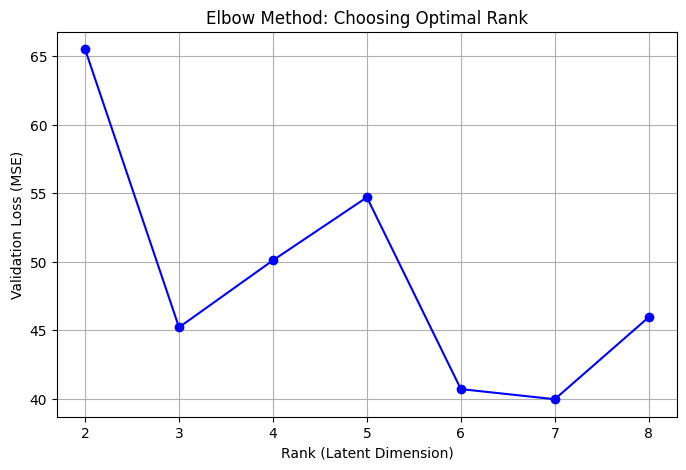

Best rank: 7 with validation loss: 39.9580


In [24]:
# Train the low-rank model with fixed settings
def train_low_rank_model(rank, num_epochs=500, lr=0.01):
    """Train low-rank model for a given rank and return validation loss."""
    m, feature_dim = features.shape
    n = ratings_df.shape[1]  # Number of users

    # Use the fixed projection layer instead of recreating it inside the function
    projection = create_fixed_projection(feature_dim, rank)
    
    # Use the same projection weights every time
    U_init = projection(torch.tensor(features, dtype=torch.float32, device=device))

    # Fix initialization of U and V
    torch.manual_seed(SEED)  # Ensure U and V initialization are the same
    U = torch.nn.Parameter(U_init)
    V = torch.nn.Parameter(torch.randn(n, rank, device=device))

    optimizer = torch.optim.Adam([U, V], lr=lr)

    lambda_reg = 0.05 # Regularization strength
    for epoch in range(num_epochs):
        pred = U @ V.t()
        diff_train = (pred - M_tensor)[train_mask]
        loss = torch.mean(diff_train ** 2) + lambda_reg * (torch.norm(U) + torch.norm(V))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 50 == 0:
            print(f"Rank {rank}, Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Compute validation loss
    diff_val = (pred - M_tensor)[val_mask]
    val_loss = torch.mean(diff_val ** 2).item()

    return val_loss  # Return final validation loss

# Try multiple rank values and find the best
ranks = [2, 3, 4, 5, 6, 7, 8]
num_trials = 3  # Run 5 trials per rank for stability
rank_losses = {r: np.mean([train_low_rank_model(r) for _ in range(num_trials)]) for r in ranks}

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(rank_losses.keys(), rank_losses.values(), marker='o', linestyle='-', color='b')
plt.xlabel("Rank (Latent Dimension)")
plt.ylabel("Validation Loss (MSE)")
plt.title("Elbow Method: Choosing Optimal Rank")
plt.xticks(ranks)  # Ensure x-axis shows only tested ranks
plt.grid(True)
plt.show()

# Find the best rank
best_rank = min(rank_losses, key=rank_losses.get)
print(f"Best rank: {best_rank} with validation loss: {rank_losses[best_rank]:.4f}")

Initialize U and V

In [25]:
# Step 3: Use best rank for final training
m, feature_dim = features.shape # Number of items
n = ratings_df.shape[1] # Number of users

# Use the fixed projection layer instead of recreating it inside the function
projection = create_fixed_projection(feature_dim, best_rank)
    
# Use the same projection weights every time
U_init = projection(torch.tensor(features, dtype=torch.float32, device=device))

# Fix initialization of U and V
torch.manual_seed(SEED)
U = torch.nn.Parameter(U_init)
V = torch.nn.Parameter(torch.randn(n, best_rank, device=device))


# projection = torch.nn.Linear(feature_dim, best_rank).to(device)
# U_init = projection(torch.tensor(features, dtype=torch.float32, device=device))

# U = torch.tensor(U_init.detach(), dtype=torch.float32, device=device, requires_grad=True)
# V = torch.randn(n, best_rank, device=device, requires_grad=True)

Set up optimizer and training loop:

Here we use the Adam optimizer, but could also try plain SGD or any other solver.

In [26]:
optimizer = torch.optim.Adam([U, V], lr=1e-2)
num_epochs = 1000

for epoch in range(num_epochs):
    # Forward: predicted matrix (m x n)
    pred = U @ V.t()
    
    # We only compute error on known entries
    diff = pred - M_tensor
    diff_known = diff[mask_tensor]  # 1D tensor of differences for known entries
    
    # MSE on known entries
    loss = torch.mean(diff_known**2)
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # (Optional) print progress occasionally
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss = {loss.item():.4f}")

Epoch 100/1000 - Loss = 4.6818
Epoch 200/1000 - Loss = 0.7901
Epoch 300/1000 - Loss = 0.3826
Epoch 400/1000 - Loss = 0.2204
Epoch 500/1000 - Loss = 0.1264
Epoch 600/1000 - Loss = 0.0779
Epoch 700/1000 - Loss = 0.0503
Epoch 800/1000 - Loss = 0.0328
Epoch 900/1000 - Loss = 0.0218
Epoch 1000/1000 - Loss = 0.0153


In [27]:
# Convert predictions back to a DataFrame
pred_np = pred.detach().cpu().numpy()  # shape (m, n)
predicted_df = pd.DataFrame(pred_np, 
                            index=ratings_df.index, 
                            columns=ratings_df.columns)

In [28]:
predicted_df.head()

,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma
0,6.102363,-0.792668,3.589234,9.847689,-6.827583,5.751329,-15.020555,7.270594,-6.751403,5.081366
1,7.007495,13.935666,9.857121,6.900910,4.947954,8.502870,2.957515,8.128237,-5.548446,21.463140
2,4.756330,1.737603,-1.010171,10.002232,3.307625,4.985184,5.993656,9.779722,6.999017,5.636561
3,6.161279,10.297307,9.998354,-1.003003,1.801311,3.992696,-1.004686,7.364518,5.999398,5.046899
4,12.539878,3.983325,10.018572,-2.103371,1.127121,5.008437,-0.996707,9.443227,-5.567112,4.996261


### Generate recommendations for users

In [29]:
def get_top_n_recs_for_user(
    user_name,
    ratings_df,     # second sheet with actual user ratings
    predictions_df, # same shape, but predicted ratings
    original_df,      # your df from the first sheet, which has 'image_path'
    n=5
):
    # 1) All predicted ratings for this user
    user_pred = predictions_df[user_name]
    
    # 2) Actual ratings for this user
    user_actual = ratings_df[user_name]
    
    # 3) Identify items that are not chosen or rated by user
    unrated = user_actual.isna() | (user_actual == 0)
    not_chosen = (original_df["user"].str.lower() != user_name.lower())
    combined_mask = unrated & not_chosen

    # 4) Sort by highest predicted rating
    top_n_idx = user_pred[combined_mask].sort_values(ascending=False, kind="mergesort").head(n).index
    
    # 5) Build a recommended subset from ratings_df (or from sheet2)
    recs = ratings_df.loc[top_n_idx].copy()
    recs["predicted_rating"] = user_pred.loc[top_n_idx].values
    
    # 6) Join with the first sheet to get brand/name/description/image_path
    #    This works IF ratings_df and df share the same index for each item
    recs = recs.join(original_df[["brand","name","description","price","image_path"]], 
                     how="left")
    
    return recs

In [30]:
for user in ["Matt", "Laura", "Vivian", "Megan", "Brianna", "Sophia"]:
    top_recs = get_top_n_recs_for_user(
        user_name=user,
        ratings_df=ratings_df,
        predictions_df=predicted_df,
        original_df=df,
        n=5
    )
    print(f"Top 5 recommended items for user '{user}':")
    display(top_recs)
    

    html_snippet = '<div style="display:flex; flex-direction:row;">'
    for idx, row in top_recs.iterrows():
        img_path = row.get("image_path")
        if img_path and os.path.isfile(img_path):
            # Add an <img> tag with a bit of spacing
            html_snippet += f'<div style="margin-right:10px;"><img src="{img_path}" width="200"/></div>'
        else:
            # You could skip or add a placeholder
            html_snippet += '<div style="width:200px;height:200px;margin-right:10px;">No image</div>'
    html_snippet += '</div>'
    
    display(HTML(html_snippet))

Top 5 recommended items for user 'Matt':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
4,NaN,4.0,10.0,NaN,NaN,5.0,-1.0,NaN,NaN,5.0,12.539878,wonderwonder,Blena Heart Strap Button Lace Cropped Sleevele...,Country of Origin : Korea/China(OEM)\nMaterial...,24.57,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
24,NaN,10.0,8.0,NaN,NaN,9.0,9.0,NaN,7.0,NaN,10.541340,A&F,High Rise 90s Relaxed Jean,Our classic relaxed jeans in a medium wash wit...,90.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
33,NaN,7.0,10.0,-1.0,NaN,NaN,-1.0,9.0,NaN,5.0,10.436924,Lewkin,Loose-Fit One-Shoulder Sweater IF505,"Style : Casual, Romantic, Feminine\nOccasion :...",30.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
20,NaN,5.0,10.0,NaN,NaN,-1.0,-1.0,NaN,-1.0,NaN,10.350213,Brandy Mellville,Skylar Floral Tank\n,Fitted floral eyelet tank top with a scallop s...,20.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
27,NaN,5.0,-1.0,10.0,NaN,NaN,-1.0,7.0,-1.0,10.0,7.828843,White House Black Market,Elbow Sleeve Mock Neck Sweater,Functional snap buttons on the left shoulder a...,79.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Laura':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
5,-1.0,NaN,10.0,NaN,NaN,NaN,7.0,8.0,NaN,6.0,18.021696,binary01,Kikuni Frill Midi Skirt,Country of Origin : Korea\nMaterial : Cotton 1...,36.02,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
23,-1.0,NaN,10.0,NaN,NaN,6.0,1.0,9.0,5.0,NaN,14.675094,Lewkin,Lace-Trim Crop Tank Top CJ509\n\n,Style : Street\nDetail : Lace\nPrint : Solid\n...,40.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
1,7.0,NaN,10.0,7.0,NaN,NaN,3.0,8.0,NaN,NaN,13.935666,gifteabox,"Denim for all seasons, 3-length vintage Faded ...",Country of Origin : China(OEM)\nMaterial : 100...,25.68,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
68,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,11.516720,Maje,Short tweed dress,The studio has reinterpreted the Parisian offi...,445.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
18,-1.0,NaN,10.0,NaN,NaN,NaN,-1.0,NaN,NaN,-1.0,11.255692,Brandy Melville,Bonnie 44 Top\n,Cotton blend off the shoulder short sleeve cro...,18.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Vivian':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
41,-1.0,10.0,5.0,NaN,NaN,7.0,-1.0,NaN,5.0,7.0,9.223658,Aritzia,westend denim dress,This is a crewneck maxi dress with a centre ba...,73.99,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
38,-1.0,10.0,NaN,NaN,NaN,9.0,-1.0,NaN,-1.0,NaN,4.539079,Aritzia,90s slit midi dress,This is a squareneck maxi dress with a darted ...,128.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
39,-1.0,10.0,6.0,NaN,NaN,9.0,-1.0,NaN,-1.0,NaN,4.518372,Aritzia,madelyn satin dress,This is a squareneck dress with adjustable str...,37.99,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
22,-1.0,10.0,8.0,NaN,NaN,8.0,-1.0,NaN,-1.0,NaN,4.517593,Aritzia,technique poplin dress,This is a V-neck fit-and-flare dress with a sm...,168.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
6,10.0,NaN,NaN,NaN,NaN,9.0,6.0,NaN,NaN,9.0,3.835520,Uniqlo,AIRism Cotton Oversized T-Shirt | Half-Sleeve,- Sheer: Not Sheer\n- Fit: Oversized\n- Pocket...,19.90,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Megan':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
47,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.373395,Zara,Denim Effect Ruffle Mini Dress,Sleeveless mini dress with round neckline. Flo...,49.90,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
57,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.200683,Zara,HALTER GODET DRESS ZW COLLECTION,Short halter neck dress with open shoulders. G...,35.99,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
48,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.022488,Zara,TRF Denim Midi Dress,Midi dress with a straight neckline and off-th...,69.90,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
58,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.380348,Zara,SHORT SLEEVE MINI DRESS,"Round neck, short sleeve dress. Topstitched de...",49.90,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
46,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.156506,Zara,Draped Midi Dress,Midi dress made of knit fabric. Sleeveless des...,49.90,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Brianna':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
5,-1.0,NaN,10.0,NaN,NaN,NaN,7.0,8.0,NaN,6.0,9.943954,binary01,Kikuni Frill Midi Skirt,Country of Origin : Korea\nMaterial : Cotton 1...,36.02,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
24,NaN,10.0,8.0,NaN,NaN,9.0,9.0,NaN,7.0,NaN,8.505350,A&F,High Rise 90s Relaxed Jean,Our classic relaxed jeans in a medium wash wit...,90.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
32,NaN,10.0,6.0,NaN,NaN,8.0,NaN,7.0,6.0,NaN,7.585477,A&F,High Rise Vintage Flare Jean,Our on-trend 70's-inspired vintage flare jeans...,90.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
17,NaN,10.0,6.0,NaN,NaN,NaN,NaN,7.0,5.0,NaN,7.547499,Aritzia,clara merino wool sweater,This is a fully fashioned polo sweater with an...,89.60,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
30,4.0,10.0,7.0,NaN,NaN,NaN,9.0,6.0,NaN,7.0,7.542531,A&F,Mid Rise Slouchy Jean,Our new mid rise slouchy jeans in a medium was...,90.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Sophia':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
27,NaN,5.0,-1.0,10.0,NaN,NaN,-1.0,7.0,-1.0,10.0,13.826076,White House Black Market,Elbow Sleeve Mock Neck Sweater,Functional snap buttons on the left shoulder a...,79.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
34,8.0,10.0,NaN,NaN,NaN,NaN,5.0,8.0,-1.0,9.0,9.952531,A&F,Cable Knit Turtleneck Sweater,Easy-fitting sweater in our super soft sweater...,54.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
5,-1.0,NaN,10.0,NaN,NaN,NaN,7.0,8.0,NaN,6.0,9.015761,binary01,Kikuni Frill Midi Skirt,Country of Origin : Korea\nMaterial : Cotton 1...,36.02,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
7,10.0,5.0,NaN,NaN,NaN,NaN,5.0,6.0,-1.0,NaN,8.751855,Uniqlo,Crew Neck T-Shirt,The Uniqlo U collection is the realization of ...,14.90,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
1,7.0,NaN,10.0,7.0,NaN,NaN,3.0,8.0,NaN,NaN,8.502870,gifteabox,"Denim for all seasons, 3-length vintage Faded ...",Country of Origin : China(OEM)\nMaterial : 100...,25.68,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


### Evaluate Model Performance

In [31]:
def train_test_split_known_entries(R, test_ratio=0.2, seed=42):
    """
    Given a rating matrix R (NumPy array) with NaNs for missing entries,
    randomly select a fraction of the KNOWN entries (non-NaN) to be the test set,
    and mask them out in the train set.
    
    Returns:
      R_train: same shape as R, but some known entries replaced with NaN
      R_test : a dictionary of (i, j) -> rating for the test entries
    """
    np.random.seed(seed)
    
    # Indices of all known (non-NaN) entries
    known_indices = np.argwhere(~np.isnan(R))
    
    # Shuffle them
    np.random.shuffle(known_indices)
    
    # How many go to test
    n_test = int(len(known_indices) * test_ratio)
    
    test_indices = known_indices[:n_test]
    train_indices = known_indices[n_test:]
    
    # Build R_train
    R_train = R.copy()
    for i, j in test_indices:
        R_train[i, j] = np.nan  # hide these ratings from training
    
    # Build R_test as a dictionary
    R_test = {}
    for i, j in test_indices:
        R_test[(i, j)] = R[i, j]
    
    return R_train, R_test

In [32]:
def factorize_low_rank(R_train, rank=3, lr=1e-2, epochs=500, verbose=False):
    """
    Factorize R_train (shape m x n) using Burer-Monteiro approach with PyTorch.
    Returns U, V, plus the final predicted matrix pred (np array).
    """
    
    # Build known_mask for train
    known_mask = ~np.isnan(R_train)
    R_filled = np.nan_to_num(R_train, nan=0.0)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    M_tensor = torch.tensor(R_filled, dtype=torch.float32, device=device)
    mask_tensor = torch.tensor(known_mask, dtype=torch.bool, device=device)
    
    m, n = M_tensor.shape
    
    # Initialize
    U = torch.randn(m, rank, device=device, requires_grad=True)
    V = torch.randn(n, rank, device=device, requires_grad=True)
    
    optimizer = torch.optim.Adam([U, V], lr=lr)
    
    for epoch in range(epochs):
        pred = U @ V.t()  # shape (m, n)
        
        diff = pred - M_tensor
        diff_known = diff[mask_tensor]  # only known entries
        loss = torch.mean(diff_known**2)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if verbose and (epoch+1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss={loss.item():.4f}")
    
    # Final prediction matrix
    pred_np = (U @ V.t()).detach().cpu().numpy()
    
    return U, V, pred_np

In [33]:
def compute_test_metrics(pred_np, R_test):
    """
    pred_np: np array, shape (m, n), reconstructed ratings
    R_test: dict of {(i, j): rating} for the test set
    
    Returns: MSE, RMSE
    """
    se = 0.0
    count = 0
    for (i, j), actual_rating in R_test.items():
        pred_rating = pred_np[i, j]
        se += (actual_rating - pred_rating)**2
        count += 1
    if count == 0:
        return None, None  # edge case
    mse = se / count
    rmse = np.sqrt(mse)
    return mse, rmse


# Example usage (putting it all together):

# 1) Train-test split on known entries
R_train, R_test = train_test_split_known_entries(R, test_ratio=0.2, seed=42)

# 2) Factorize only on R_train
U, V, pred_np = factorize_low_rank(R_train, rank=3, lr=1e-2, epochs=500, verbose=True)

# 3) Evaluate on test set
mse, rmse = compute_test_metrics(pred_np, R_test)
print(f"Low-Rank Matrix Completion Test MSE = {mse:.4f}, RMSE = {rmse:.4f}")

Epoch 50/500, Loss=38.5004
Epoch 100/500, Loss=20.2519
Epoch 150/500, Loss=10.0478
Epoch 200/500, Loss=6.3039
Epoch 250/500, Loss=4.5291
Epoch 300/500, Loss=3.5692
Epoch 350/500, Loss=2.9558
Epoch 400/500, Loss=2.4357
Epoch 450/500, Loss=2.0261
Epoch 500/500, Loss=1.7555
Low-Rank Matrix Completion Test MSE = 32.8913, RMSE = 5.7351


## Scale 1, -1

In [34]:
binary_ratings_df = ratings_df.copy()
# Convert non-NaN values: 1 if >=7, -1 otherwise
binary_ratings_df[:] = np.where(ratings_df.notna(), np.where(ratings_df >= 7, 1, -1), np.nan)

print(binary_ratings_df.head())

   Matt  Laura  Megan  Vivian  Brianna  Sophia  Jake  Lily  Alex  Emma
0  -1.0   -1.0   -1.0     1.0      NaN    -1.0   NaN   1.0   NaN  -1.0
1   1.0    NaN    1.0     1.0      NaN     NaN  -1.0   1.0   NaN   NaN
2   NaN    NaN   -1.0     1.0      NaN    -1.0  -1.0   NaN   1.0   NaN
3   NaN    NaN    1.0    -1.0      NaN    -1.0  -1.0   NaN  -1.0   NaN
4   NaN   -1.0    1.0     NaN      NaN    -1.0  -1.0   NaN   NaN  -1.0


Create the Rating Matrix for binary_ratings_df

In [35]:
# Convert binary_ratings_df to a NumPy array
R_binary = binary_ratings_df.values.astype(np.float32)

# Get dimensions (m = items, n = users)
m, n = R_binary.shape
print("Shape of binary rating matrix:", R_binary.shape)

# Create a mask: True for known ratings, False for missing ratings
known_mask_binary = ~np.isnan(R_binary)

# Convert to PyTorch tensors
M_tensor_binary = torch.tensor(R_binary, dtype=torch.float32, device=device)
mask_tensor_binary = torch.tensor(known_mask_binary, dtype=torch.bool, device=device)

# Set missing values to 0 in M_tensor, but mask ensures they are ignored
M_tensor_binary[~mask_tensor_binary] = 0

Shape of binary rating matrix: (73, 10)


Implement Low-Rank Factorization for binary_ratings_df

In [36]:
def fixed_train_test_split_binary(known_mask, test_ratio=0.2):
    """Ensure consistent train-test split by fixing random seed."""
    np.random.seed(SEED)
    
    known_indices = np.argwhere(known_mask)
    np.random.shuffle(known_indices)
    
    n_test = int(len(known_indices) * test_ratio)
    
    test_indices = known_indices[:n_test]
    train_indices = known_indices[n_test:]

    train_mask = np.zeros_like(known_mask, dtype=bool)
    val_mask = np.zeros_like(known_mask, dtype=bool)

    train_mask[train_indices[:, 0], train_indices[:, 1]] = True
    val_mask[test_indices[:, 0], test_indices[:, 1]] = True

    return train_mask, val_mask

# Compute train-validation split once and reuse it
train_mask_binary, val_mask_binary = fixed_train_test_split_binary(known_mask_binary)

Rank 2, Epoch 50/500, Loss: 1.1416
Rank 2, Epoch 100/500, Loss: 0.9196
Rank 2, Epoch 150/500, Loss: 0.8691
Rank 2, Epoch 200/500, Loss: 0.8478
Rank 2, Epoch 250/500, Loss: 0.8347
Rank 2, Epoch 300/500, Loss: 0.8280
Rank 2, Epoch 350/500, Loss: 0.8236
Rank 2, Epoch 400/500, Loss: 0.8188
Rank 2, Epoch 450/500, Loss: 0.8108
Rank 2, Epoch 500/500, Loss: 0.7939
Rank 2, Epoch 50/500, Loss: 1.1416
Rank 2, Epoch 100/500, Loss: 0.9196
Rank 2, Epoch 150/500, Loss: 0.8691
Rank 2, Epoch 200/500, Loss: 0.8478
Rank 2, Epoch 250/500, Loss: 0.8347
Rank 2, Epoch 300/500, Loss: 0.8280
Rank 2, Epoch 350/500, Loss: 0.8236
Rank 2, Epoch 400/500, Loss: 0.8188
Rank 2, Epoch 450/500, Loss: 0.8108
Rank 2, Epoch 500/500, Loss: 0.7939
Rank 2, Epoch 50/500, Loss: 1.1416
Rank 2, Epoch 100/500, Loss: 0.9196
Rank 2, Epoch 150/500, Loss: 0.8691
Rank 2, Epoch 200/500, Loss: 0.8478
Rank 2, Epoch 250/500, Loss: 0.8347
Rank 2, Epoch 300/500, Loss: 0.8280
Rank 2, Epoch 350/500, Loss: 0.8236
Rank 2, Epoch 400/500, Loss: 0.

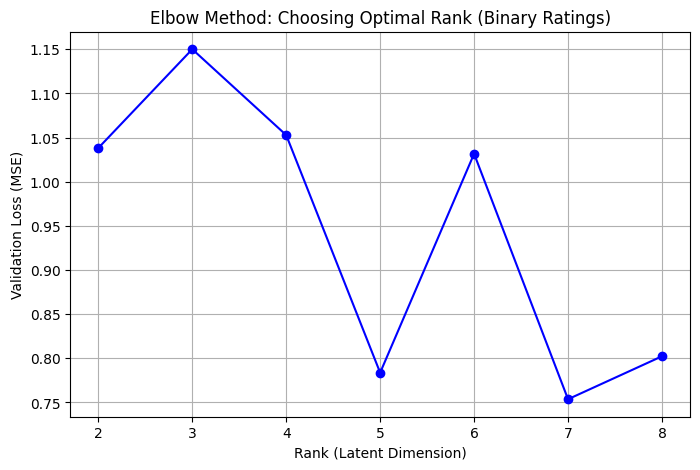

Best rank: 7 with validation loss: 0.7536


In [37]:
def train_low_rank_model_binary(rank, num_epochs=500, lr=0.01):
    """Train low-rank model for binary_ratings_df and return validation loss."""
    
    # Use the fixed projection layer instead of recreating it inside the function
    projection_binary = create_fixed_projection(feature_dim, rank)

    # Use the same projection weights every time
    U_init_binary = projection_binary(torch.tensor(features, dtype=torch.float32, device=device))

    # Fix initialization of U and V
    torch.manual_seed(SEED)  # Ensure U and V initialization are the same
    U_binary = torch.nn.Parameter(U_init_binary)
    V_binary = torch.nn.Parameter(torch.randn(n, rank, device=device))

    optimizer = torch.optim.Adam([U_binary, V_binary], lr=lr)

    lambda_reg = 0.05  # Regularization strength to prevent overfitting

    for epoch in range(num_epochs):
        pred_binary = U_binary @ V_binary.t()

        # Compute loss only on known training ratings
        diff_train = (pred_binary - M_tensor_binary)[train_mask_binary]
        loss = torch.mean(diff_train ** 2) + lambda_reg * (torch.norm(U_binary) + torch.norm(V_binary))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (epoch+1) % 50 == 0:
            print(f"Rank {rank}, Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Compute validation loss
    diff_val = (pred_binary - M_tensor_binary)[val_mask_binary]
    val_loss = torch.mean(diff_val ** 2).item()

    return val_loss  # Return final validation loss

# Define rank values to test
ranks = [2, 3, 4, 5, 6, 7, 8]
num_trials = 3
rank_losses_binary = {r: np.mean([train_low_rank_model_binary(r) for _ in range(num_trials)]) for r in ranks}

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(rank_losses_binary.keys(), rank_losses_binary.values(), marker='o', linestyle='-', color='b')
plt.xlabel("Rank (Latent Dimension)")
plt.ylabel("Validation Loss (MSE)")
plt.title("Elbow Method: Choosing Optimal Rank (Binary Ratings)")
plt.xticks(ranks)  # Ensure x-axis shows only tested ranks
plt.grid(True)
plt.show()

# Find the best rank
best_rank_binary = min(rank_losses_binary, key=rank_losses_binary.get)
print(f"Best rank: {best_rank_binary} with validation loss: {rank_losses_binary[best_rank_binary]:.4f}")

In [38]:
# Use best rank for final training
m, feature_dim = features.shape  # Number of items
n = binary_ratings_df.shape[1]  # Number of users

# Create fixed projection layer
projection_binary = create_fixed_projection(feature_dim, best_rank_binary)

# Project item features into `rank`-dimensional space
U_init_binary = projection_binary(torch.tensor(features, dtype=torch.float32, device=device))

# Convert to trainable parameters
torch.manual_seed(SEED)  # Ensure consistent initialization
U_binary = torch.nn.Parameter(U_init_binary)
V_binary = torch.nn.Parameter(torch.randn(n, best_rank_binary, device=device))

optimizer_binary = torch.optim.Adam([U_binary, V_binary], lr=1e-2)
num_epochs = 1000

lambda_reg = 0.05  # Regularization strength

for epoch in range(num_epochs):
    # Forward: predicted matrix (m x n)
    pred_binary = U_binary @ V_binary.t()
    
    # Compute loss only on known ratings
    diff_binary = pred_binary - M_tensor_binary
    diff_known_binary = diff_binary[mask_tensor_binary]

    # Compute MSE loss with regularization
    loss_binary = torch.mean(diff_known_binary**2) + lambda_reg * (torch.norm(U_binary) + torch.norm(V_binary))

    # Backpropagation
    optimizer_binary.zero_grad()
    loss_binary.backward()
    optimizer_binary.step()
    
    # Print progress occasionally
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss = {loss_binary.item():.4f}")

# Convert predictions back to a DataFrame
pred_np_binary = pred_binary.detach().cpu().numpy()  # shape (m, n)
predicted_binary_df = pd.DataFrame(pred_np_binary, 
                                   index=binary_ratings_df.index, 
                                   columns=binary_ratings_df.columns)

Epoch 100/1000 - Loss = 0.9868
Epoch 200/1000 - Loss = 0.7655
Epoch 300/1000 - Loss = 0.6815
Epoch 400/1000 - Loss = 0.6555
Epoch 500/1000 - Loss = 0.6476
Epoch 600/1000 - Loss = 0.6450
Epoch 700/1000 - Loss = 0.6440
Epoch 800/1000 - Loss = 0.6437
Epoch 900/1000 - Loss = 0.6436
Epoch 1000/1000 - Loss = 0.6435


In [39]:
predicted_binary_df.head()

,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma
0,-0.762632,-0.846926,-0.604515,0.852166,-0.182557,-0.888086,-0.230749,0.835994,0.439625,-0.682753
1,0.700592,-0.391619,0.638563,0.700851,-0.706905,-0.376229,-0.759562,0.810941,-0.471349,-0.321793
2,0.055308,-1.249403,-0.739698,0.813519,-0.386214,-0.719107,-0.459662,0.599327,0.445675,-0.522546
3,-0.238701,0.174146,0.852819,-0.794194,-0.340498,-0.746702,-0.863942,0.229879,-0.784064,-0.631740
4,-0.025860,-0.817554,0.786322,0.019271,-0.903784,-0.964362,-0.721139,0.154967,-0.279272,-0.847976


Step 3: Generate Recommendations for Users

In [40]:
# Generate recommendations for a specific user (e.g., "Laura")
for user in ["Matt", "Laura", "Vivian", "Megan", "Brianna", "Sophia"]:
    top_recs_binary = get_top_n_recs_for_user(
        user_name=user,
        ratings_df=binary_ratings_df,
        predictions_df=predicted_binary_df,
        original_df=df,
        n=5
    )

    print(f"Top 5 recommended items for user '{user}':")
    display(top_recs_binary)
    

    html_snippet = '<div style="display:flex; flex-direction:row;">'
    for idx, row in top_recs_binary.iterrows():
        img_path = row.get("image_path")
        if img_path and os.path.isfile(img_path):
            # Add an <img> tag with a bit of spacing
            html_snippet += f'<div style="margin-right:10px;"><img src="{img_path}" width="200"/></div>'
        else:
            # You could skip or add a placeholder
            html_snippet += '<div style="width:200px;height:200px;margin-right:10px;">No image</div>'
    html_snippet += '</div>'
    
    display(HTML(html_snippet))

Top 5 recommended items for user 'Matt':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
27,NaN,-1.0,-1.0,1.0,NaN,NaN,-1.0,1.0,-1.0,1.0,0.512395,White House Black Market,Elbow Sleeve Mock Neck Sweater,Functional snap buttons on the left shoulder a...,79.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
20,NaN,-1.0,1.0,NaN,NaN,-1.0,-1.0,NaN,-1.0,NaN,0.060994,Brandy Mellville,Skylar Floral Tank\n,Fitted floral eyelet tank top with a scallop s...,20.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
2,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,1.0,NaN,0.055308,Forever 21,Mid-Rise Wide-Leg Cargo Pants,A pair of twill pants featuring a mid-rise wai...,24.49,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
60,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.015809,Tommy Hilfiger,Slim Fit Zip Polo,About\nTommy Hilfiger women's polo. Designed i...,38.70,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
59,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.015733,Tommy Hilfiger,Embroidered Flag Stripe Logo T-Shirt,About\nTommy Hilfiger women's T-shirt. Made fr...,26.70,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Laura':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
64,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.747127,Brandy Melville,Christy Hoodie,"Basic, zip-up hoodie with two pockets and a dr...",45.0,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
66,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.747125,Ralph Lauren,Cable-Knit Cotton Crewneck Cardigan,"Cable-knit with pure cotton, this slim crewnec...",198.0,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
67,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.747125,Zara,STRAIGHT LEG FULL LENGTH Z1975 JEANS WITH A HI...,High-waisted jeans with five pockets. Straight...,49.9,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
70,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.747125,MaxMara,Belted wool coat,Long double-breasted coat in fine pure wool br...,875.0,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
71,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0.747125,Burberry,Long Castleford Trench Coat,A trench coat made in England from shower-resi...,2890.0,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Vivian':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
13,1.0,NaN,NaN,NaN,NaN,1.0,-1.0,1.0,-1.0,NaN,0.303784,Uniqlo,Linen Blend Relaxed Pants,- Sheer: Not Sheer\n- Fit: Regular\n- Silhouet...,49.9,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
32,NaN,1.0,-1.0,NaN,NaN,1.0,NaN,1.0,-1.0,NaN,0.246536,A&F,High Rise Vintage Flare Jean,Our on-trend 70's-inspired vintage flare jeans...,90.0,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
6,1.0,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,NaN,1.0,0.125170,Uniqlo,AIRism Cotton Oversized T-Shirt | Half-Sleeve,- Sheer: Not Sheer\n- Fit: Oversized\n- Pocket...,19.9,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
17,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,0.108597,Aritzia,clara merino wool sweater,This is a fully fashioned polo sweater with an...,89.6,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
14,1.0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,-1.0,1.0,0.080866,Uniqlo,Jersey Overshirt,- Sheer: Not Sheer\n- Fit: Relaxed\n,39.9,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Megan':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
28,-1.0,1.0,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0,NaN,0.200698,A&F,Essential Tuckable Baby Tee,Slim-fitting short-sleeve tee in our softAF co...,29.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
49,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.085975,Zara,STRIPED POPLIN SHIRT WITH CONTRASTING BUTTONS,"Collared, long-sleeved shirt. Front closure wi...",45.90,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
56,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.085969,H&M,Canvas Cargo Pants,"Pants in cotton canvas. Low waist, covered ela...",24.99,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
50,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.085956,Zara,TRF HIGH RISE WIDE LEG JEANS,High-waisted five pocket jeans in rigid fabric...,49.90,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
45,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.085925,Zara,Short Swing Dress,Sleeveless mini dress with round neckline. Swi...,59.90,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Brianna':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
37,-1.0,1.0,NaN,-1.0,NaN,1.0,-1.0,1.0,NaN,1.0,0.875809,Aritzia,leda ponte dress,This is a scoopneck fit-and-flare dress with p...,46.99,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
32,NaN,1.0,-1.0,NaN,NaN,1.0,NaN,1.0,-1.0,NaN,0.734091,A&F,High Rise Vintage Flare Jean,Our on-trend 70's-inspired vintage flare jeans...,90.00,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
17,NaN,1.0,-1.0,NaN,NaN,NaN,NaN,1.0,-1.0,NaN,0.701020,Aritzia,clara merino wool sweater,This is a fully fashioned polo sweater with an...,89.60,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
41,-1.0,1.0,-1.0,NaN,NaN,1.0,-1.0,NaN,-1.0,1.0,0.699915,Aritzia,westend denim dress,This is a crewneck maxi dress with a centre ba...,73.99,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
39,-1.0,1.0,-1.0,NaN,NaN,1.0,-1.0,NaN,-1.0,NaN,0.692531,Aritzia,madelyn satin dress,This is a squareneck dress with adjustable str...,37.99,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...


Top 5 recommended items for user 'Sophia':


,Matt,Laura,Megan,Vivian,Brianna,Sophia,Jake,Lily,Alex,Emma,predicted_rating,brand,name,description,price,image_path
31,NaN,1.0,NaN,1.0,NaN,NaN,-1.0,1.0,-1.0,1.0,0.822063,White House Black Market,V-Neck Open Stitch Sequin Sweater,The open stitch design of this pullover is jus...,99.0,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
30,-1.0,1.0,1.0,NaN,NaN,NaN,1.0,-1.0,NaN,1.0,0.789290,A&F,Mid Rise Slouchy Jean,Our new mid rise slouchy jeans in a medium was...,90.0,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
34,1.0,1.0,NaN,NaN,NaN,NaN,-1.0,1.0,-1.0,1.0,0.737504,A&F,Cable Knit Turtleneck Sweater,Easy-fitting sweater in our super soft sweater...,54.0,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
40,1.0,-1.0,-1.0,1.0,NaN,NaN,NaN,-1.0,-1.0,1.0,0.724875,Nike,Nike Sportswear Phoenix Fleece - Women's Overs...,"Grounded in style, comfort and versatility, me...",70.0,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
10,1.0,NaN,-1.0,NaN,NaN,NaN,-1.0,-1.0,NaN,1.0,0.703280,Uniqlo,Wide Straight Jeans,- Fit: Loose\n- Silhouette: Straight\n- Pocket...,49.9,/Users/laurali/Desktop/Spring 25/STAT 4830/STA...
